# IPython Notebook for animation

## Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output
import  matplotlib.animation as animation

## Set the path/ filename of the file the contains the data

In [2]:
inputfilePath = 'config_output.txt'
obsfilePath = 'obs_output.txt'

## Read the data from the files and save it in lists of floats

In [5]:
e = 1.602176634*1e-19
hbar = 1.054571817*1e-34

plotData = [] #Array to save the real part of the wave functions
with open(inputfilePath,'r') as inputfile:
    for line in inputfile:
        plotData.append(line.strip().split('\t')) #Tab is used as seperator between values
    for j in range(len(plotData)): #Cast list items from string to float type
        plotData[j] = [float(plotData[j][i]) for i in range(len(plotData[0]))] # cast entries to float
    plotData = np.array(plotData) # cast to numpy array
    
obsData = [] # Array to save the observable data
with open(obsfilePath,'r') as obsfile:
    for line in obsfile:
        obsData.append(line.strip().split('\t'))
    for j in range(len(obsData)):
        obsData[j] = [float(obsData[j][i]) for i in range(len(obsData[0]))]
    obsData = np.array(obsData).T

## Generate animation

In [ ]:
fps = 10
nSeconds = int(len(plotData)/fps)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(100,100) )

plotData = plotData.reshape(len(plotData),100,100)
im = plt.imshow(plotData[0], interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(plotData[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

..

## Graphical output of the observables

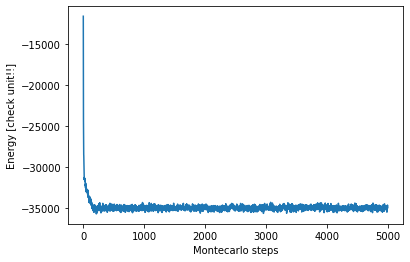

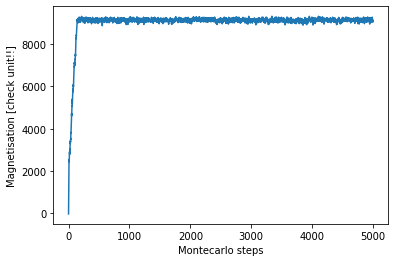

In [12]:
n_th = 0

plt.plot(obsData[0][n_th:],obsData[1][n_th:])
plt.xlabel("Montecarlo steps")
plt.ylabel("Energy [check unit!!]")
plt.show()
    
plt.plot(obsData[0][n_th:],obsData[2][n_th:])
plt.xlabel("Montecarlo steps")
plt.ylabel("Magnetisation [check unit!!]")
plt.show()